In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from tqdm import tqdm
from skimage.color import label2rgb
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.lines import Line2D
import geopandas as gpd
from orinoco import get_cropped_profile, get_extent, make_map

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', family='serif', size=20)

In [2]:
tiles = ['NH15', 'NH16', 'NR08']

In [3]:
tile_name = tiles[2]
slice_index = 1

In [4]:
out = Path('out')
grwl_data = Path('grwl_data')

tile_dir = out/tile_name
tile_dir_4326 = out/f'{tile_name}_4326'

In [5]:
list(tile_dir_4326.glob('*'))

[PosixPath('out/NR08_4326/distance.tif'),
 PosixPath('out/NR08_4326/ocean_mask.tif'),
 PosixPath('out/NR08_4326/segments.tif'),
 PosixPath('out/NR08_4326/water_mask.tif')]

In [6]:
with rasterio.open(tile_dir_4326/'segments.tif') as ds:
    segments = ds.read(1)
with rasterio.open(tile_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(tile_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)
    profile= ds.profile

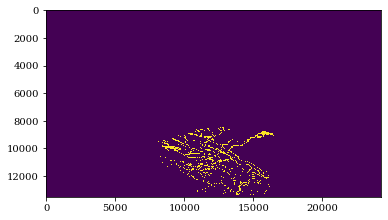

In [7]:
plt.imshow(water_mask)

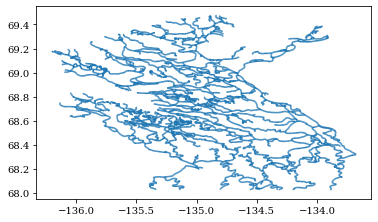

In [8]:
edges_grwl = gpd.read_file(grwl_data/'centerlines'/tile_name)

edges_fmm = gpd.read_file(tile_dir/'orinoco_edges.geojson').to_crs({'init':'epsg:4326'})
edges_fmm.plot()

In [9]:
water_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

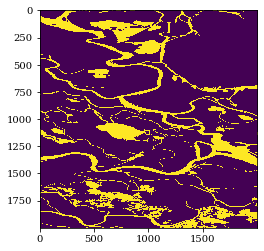

In [10]:
sy = np.s_[9_000:11_000]
sx = np.s_[11_000:13_000]
plt.imshow(water_mask[sy, sx])

In [11]:
# Morgan City
if (tile_name is 'NH15') & (slice_index == 1):
    sy = np.s_[7500:8750]
    sx = np.s_[16000:17250]

elif (tile_name is 'NH15') & (slice_index == 2):
    sy = np.s_[6_000:7_250]
    sx = np.s_[6_450:8_400]

#Mobile
elif (tile_name is 'NH16') & (slice_index == 1):
    sy = np.s_[2_500:5_000]
    sx = np.s_[6_250:8_000]

    
elif (tile_name is 'NR08') & (slice_index == 1):
    sy = np.s_[9_000:11_000]
    sx = np.s_[11_000:13_000]

# Mackenzie
elif (tile_name is 'NR08') & (slice_index == 2):
    sy = np.s_[6_000:7_000]
    sx = np.s_[7_500:8_500]
    
else:
    sy = np.s_[:]
    sx = np.s_[:]

plot_dir = Path(f'plot/{tile_name}_{slice_index}')
plot_dir.mkdir(exist_ok=True, parents=True)

In [12]:
profile_cropped = get_cropped_profile(profile, sx, sy)
extent = get_extent(profile_cropped['transform'], profile_cropped['width'], profile_cropped['height'])

In [13]:
profile_cropped = get_cropped_profile(profile, sx, sy)
extent = get_extent(profile_cropped['transform'], profile_cropped['width'], profile_cropped['height'])
extent

[-135.3378, -134.7378, 69.32399999999998, 68.72399999999999]

In [14]:
edges_fmm.total_bounds

array([-136.2037071 ,   68.02464011, -133.67587286,   69.47683925])

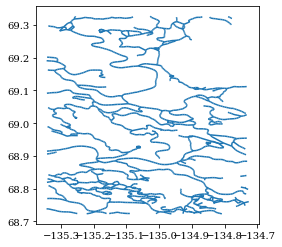

In [15]:
edges_grwl_c = edges_grwl.cx[extent[0]: extent[1], extent[3]: extent[2]]
edges_fmm_c = edges_fmm.cx[extent[0]: extent[1], extent[3]: extent[2]]
edges_fmm_c.plot()

In [16]:
ocean_layer = ocean_mask.astype(dtype=float)
ocean_layer[~ocean_mask.astype(bool)] = np.nan

In [17]:
M = 4
labels = ['Land', 'Inland Water', 'Ocean', 'Orinoco']

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=(M))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          markersize=10) for k in range(M-1)] +\
                    [Line2D([0], 
                          [0], 
                          marker=None,
                          color=scalarMap.to_rgba(M),
                          label=f'{labels[M-1]}',
                          linewidth=5,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

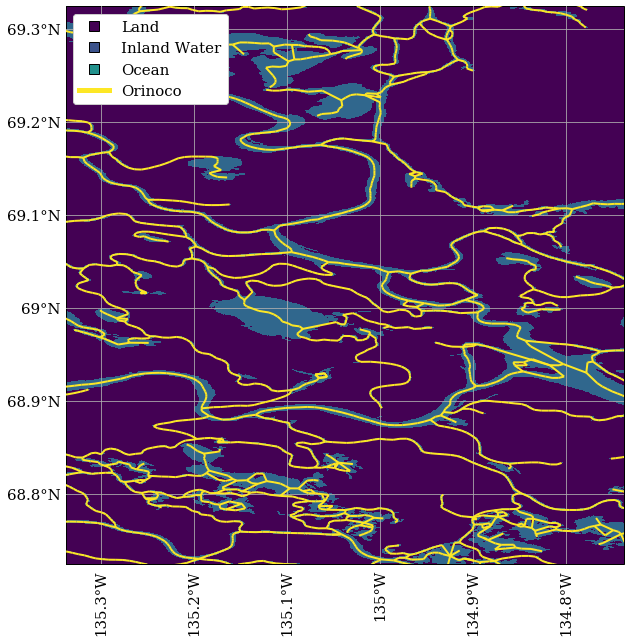

In [18]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(10, 11),
                   labels=True,
                   ticklabelsize=15
                   )
ax.set_extent([extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.PlateCarree())

ax.add_geometries(edges_fmm_c.geometry, 
              crs=ccrs.PlateCarree(), 
              edgecolor=scalarMap.to_rgba(4),
              linewidth=2,
              #linestyle='--',
              facecolor=(0, 0, 0, 0),
              zorder = 3,
             )


ax.imshow(water_mask[sy, sx], alpha=1, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))

ax.imshow(ocean_layer[sy, sx], 
          alpha=1, 
          zorder=2, 
          extent=extent,
          vmin=0, vmax=2,
          transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)
#ax.set_title('Fast Marching Method')
plt.savefig(plot_dir/'fmm.png')

In [19]:
M = 4
labels = ['Land', 'Inland Water', 'Ocean', 'GRWL']

cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=(M))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'{labels[k]}',
                          markerfacecolor=scalarMap.to_rgba(k),
                          markeredgecolor='black',
                          markersize=10) for k in range(M-1)] +\
                    [Line2D([0], 
                          [0], 
                          marker=None,
                          color=scalarMap.to_rgba(M),
                          label=f'{labels[M-1]}',
                          linewidth=5,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

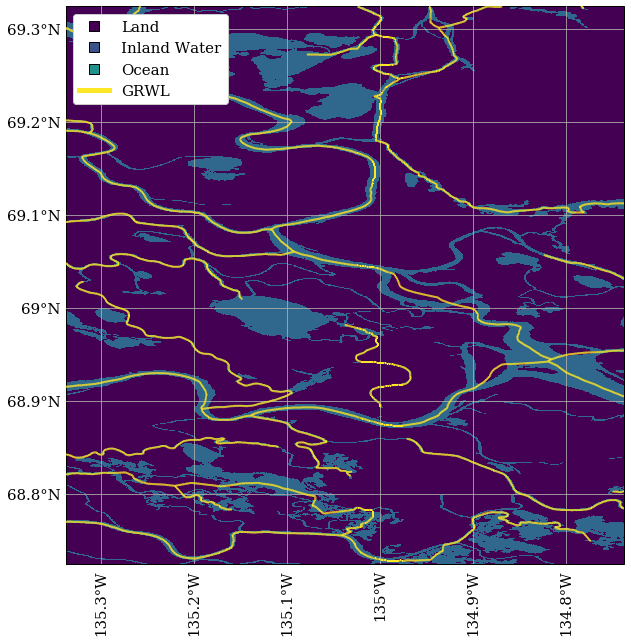

In [20]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(10, 11),
                   labels=True,
                   ticklabelsize=15,
                   )
ax.set_extent([extent[k] for k in [0, 1, 2, 3]],  crs=ccrs.PlateCarree())

#request = cimgt.Stamen('terrain-background') #GoogleTiles(style='satellite')##style='Toner')#(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#StamenTerrain()#GoogleTiles(style='satellite')
#ax.add_image(request, 10, alpha=1, zorder=1)
ax.add_geometries(edges_grwl_c.geometry, 
              crs=ccrs.PlateCarree(), 
              edgecolor=scalarMap.to_rgba(4),
              linewidth=2,
              #linestyle='--',
              facecolor=(0, 0, 0, 0),
              zorder = 3,
             )
ax.imshow(water_mask[sy, sx], alpha=1, 
             zorder=1, 
             extent=extent,
             transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=(M-1))

ax.imshow(ocean_layer[sy, sx], 
          alpha=1, 
          zorder=2, 
          extent=extent,
          vmin=0, vmax=2,
          transform=ccrs.PlateCarree())
ax.legend(handles=legend_elements, loc='upper left', fontsize=15, framealpha=1)
plt.savefig(plot_dir/'grwl.png')

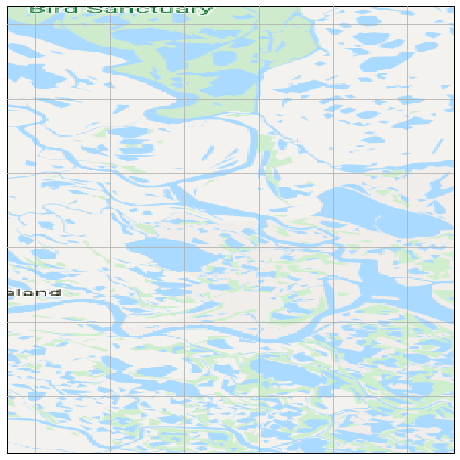

In [21]:
fig, ax = make_map(projection=ccrs.PlateCarree(), #epsg(3857)
                   figsize=(8, 11.5),
                   )
ax.set_extent(extent,  crs=ccrs.PlateCarree())

request = cimgt.GoogleTiles(style='street')#Stamen('terrain')#cimgt.GoogleTiles(style='street')#Stamen('toner')#GoogleTiles(style='street')#OSM()#GoogleTiles(style='street')#Stamen('terrain-background') #GoogleTiles(style='satellite')##style='Toner')#(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#GoogleTiles(style='satellite')#OSM()#StamenTerrain()#GoogleTiles(style='satellite')

zoom_level = 9
ax.add_image(request, zoom_level, alpha=1, zorder=1)
plt.savefig(plot_dir/'map.png')